In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import qutip as qt
import scipy.constants as sc
from joblib import Parallel, delayed
from functools import partial
from mode import CavityMode, QuantumMode, SNAILMode
from hamiltonian import Hamiltonian, QubitQubitSNAIL
from pulse import Pulse
from system import QuantumSystem

In [20]:
def get_pop_dist(states, mode, quantum_system):
    population = np.zeros((len(states), mode.dim))
    for k, state in enumerate(tqdm(states)):
        for i in range(mode.dim):
            population[k][i] = quantum_system.mode_population_expectation(state, mode, i)
    return population 


def simulation_task(freq_amp_pair, system_hamiltonian_params, psi0, tlist, collapse_ops, drive_1_args):
    """Runs a simulation for a given frequency and amplitude."""
    freq, amp = freq_amp_pair

    # Reconstruct the Hamiltonian in each process
    quantum_system = QuantumSystem.from_yaml(system_hamiltonian_params["yaml_file"])
    system_hamiltonian = QubitQubitSNAIL(quantum_system, **system_hamiltonian_params["kwargs"])

    # Define the drive with the new parameters
    drive = Pulse(omega=freq, amp=amp, phi=0)
    system_driven = system_hamiltonian.driven(drive)

    # Solve the system
    result = qt.mesolve(
        system_driven, psi0, tlist, collapse_ops,
        args=drive_1_args, options={"store_states": True, "progress_bar": "enhanced", "rtol": 1e-8, "atol": 1e-10, "nsteps": 1e6}
    )

    return result


def convert_array(param):
    """Ensure the input is a NumPy array."""
    if isinstance(param, (int, float)):  # If a single number, convert to an array
        return np.array([param])
    return np.array(param)  # If already a list/array, convert it to a NumPy array


if __name__ == '__main__':

    yaml_file = r"D:/Github/Qutip/Evan/system_params.yaml"

    # Store only necessary parameters instead of passing objects directly
    system_hamiltonian_params = {
        "yaml_file": yaml_file,
        "kwargs": {"use_RWA": False, "use_TLS": False}
    }

    quantum_system = QuantumSystem.from_yaml(yaml_file)
    system_hamiltonian = QubitQubitSNAIL(quantum_system, **system_hamiltonian_params["kwargs"])
    psi0 = quantum_system.prepare_tensor_fock_state([(system_hamiltonian.q2_mode, 1)])
    # collapse_ops = [i.collapse_operators()[0] for i in quantum_system.modes]
    collapse_ops = []
    
    width_d = 400
    tlist = np.linspace(0, 1500, 15001)

    # Additional pulse args used in mesolve
    drive_1_args = {"shape": Pulse.smoothbox, "shape_params": {"t0": 300, "width": width_d}}

    detune = 2 * np.pi * 0.0
    amp_d = 10

    flist = convert_array(detune) + np.abs((system_hamiltonian.q1_mode.freq - system_hamiltonian.q2_mode.freq)) * 2 * np.pi
    alist = convert_array(amp_d)

    freq_amp_pairs = list(itertools.product(flist, alist))

    

In [6]:
# Parallel execution using joblib
results = Parallel(n_jobs=10, verbose=10)(delayed(simulation_task)(pair, system_hamiltonian_params, psi0, tlist, collapse_ops, drive_1_args) for pair in freq_amp_pairs)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   40.8s


In [2]:
#  # calculate expectation values
# psi_q2_0_i = quantum_system.mode_population_expectation(psi0, system_hamiltonian.q2_mode, 0)
# psi_q2_0_f = quantum_system.mode_population_expectation(results[0].states[-1], system_hamiltonian.q2_mode, 0)
# psi_q2_1_i = quantum_system.mode_population_expectation(psi0, system_hamiltonian.q2_mode, 1)
# psi_q2_1_f = quantum_system.mode_population_expectation(results[0].states[-1], system_hamiltonian.q2_mode, 1)

# print(f"overlap between psi0 and a prepped initial state says Q2 is in |g> = {psi_q2_0_i:.3f} \noverlap between final state and a prepped initial state says Q2 is in |g> = {psi_q2_0_f:.3f}")
# print(f"overlap between psi0 and a prepped initial state says Q2 is in |e> = {psi_q2_1_i:.3f} \noverlap between final state and a prepped initial state says Q2 is in |e> = {psi_q2_1_f:.3f}")

# psi_q1_0_i = quantum_system.mode_population_expectation(psi0, system_hamiltonian.q1_mode, 0)
# psi_q1_0_f = quantum_system.mode_population_expectation(results[0].states[-1], system_hamiltonian.q1_mode, 0)
# psi_q1_1_i = quantum_system.mode_population_expectation(psi0, system_hamiltonian.q1_mode, 1)
# psi_q1_1_f = quantum_system.mode_population_expectation(results[0].states[-1], system_hamiltonian.q1_mode, 1)

# print(f"overlap between psi0 and a prepped initial state says Q1 is in |g> = {psi_q1_0_i:.3f} \noverlap between final state and a prepped initial state says Q1 is in |g> = {psi_q1_0_f:.3f}")
# print(f"overlap between psi0 and a prepped initial state says Q1 is in |e> = {psi_q1_1_i:.3f} \noverlap between final state and a prepped initial state says Q1 is in |e> = {psi_q1_1_f:.3f}")

In [7]:
#extract data
s_pop = get_pop_dist(results[0].states, system_hamiltonian.snail_mode, quantum_system)
q1_pop = get_pop_dist(results[0].states, system_hamiltonian.q1_mode, quantum_system)
q2_pop = get_pop_dist(results[0].states, system_hamiltonian.q2_mode, quantum_system)

del results

100%|██████████| 15001/15001 [00:12<00:00, 1188.15it/s]


In [8]:
s_pop_tavg = [np.mean(s_pop[:, i]) for i in range(system_hamiltonian.snail_mode.dim)]
q1_pop_tavg = [np.mean(q1_pop[:, i]) for i in range(system_hamiltonian.q1_mode.dim)]
q2_pop_tavg = [np.mean(q2_pop[:, i]) for i in range(system_hamiltonian.q2_mode.dim)]

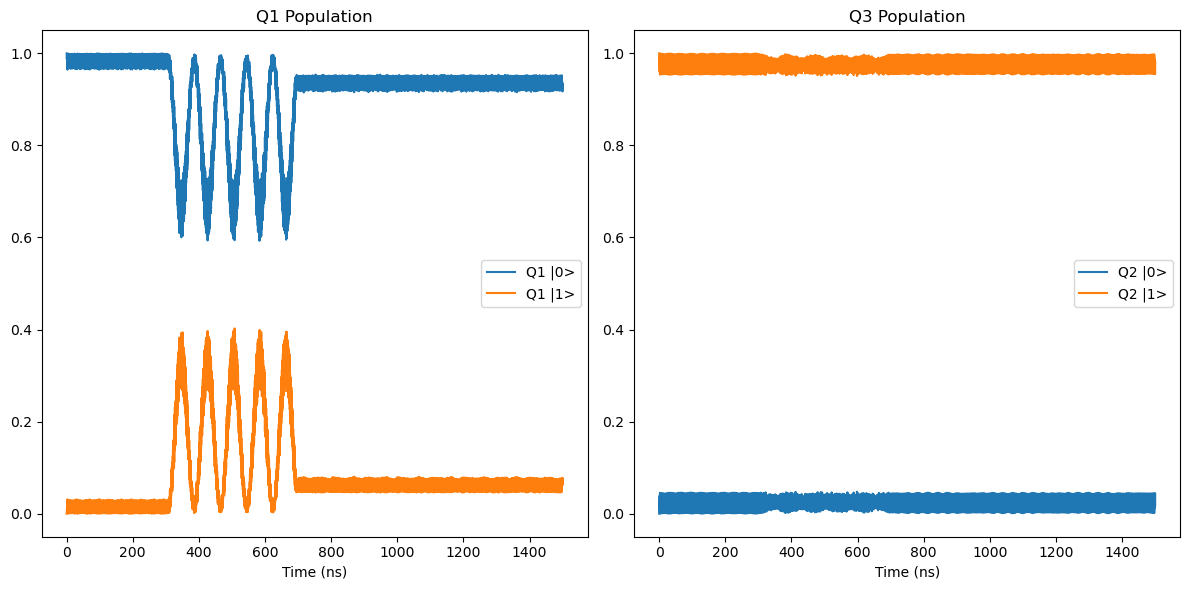

In [30]:

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a 2-row subplot

axs[0].plot(tlist, q1_pop[:, 0], label='Q1 |0>')
axs[0].plot(tlist, q1_pop[:, 1], label='Q1 |1>')
axs[0].legend()
axs[0].set_xlabel("Time (ns)")
axs[0].set_title("Q1 Population")

axs[1].plot(tlist, q2_pop[:, 0], label='Q2 |0>')
axs[1].plot(tlist, q2_pop[:, 1], label='Q2 |1>')
axs[1].legend()
axs[1].set_xlabel("Time (ns)")
axs[1].set_title("Q3 Population")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

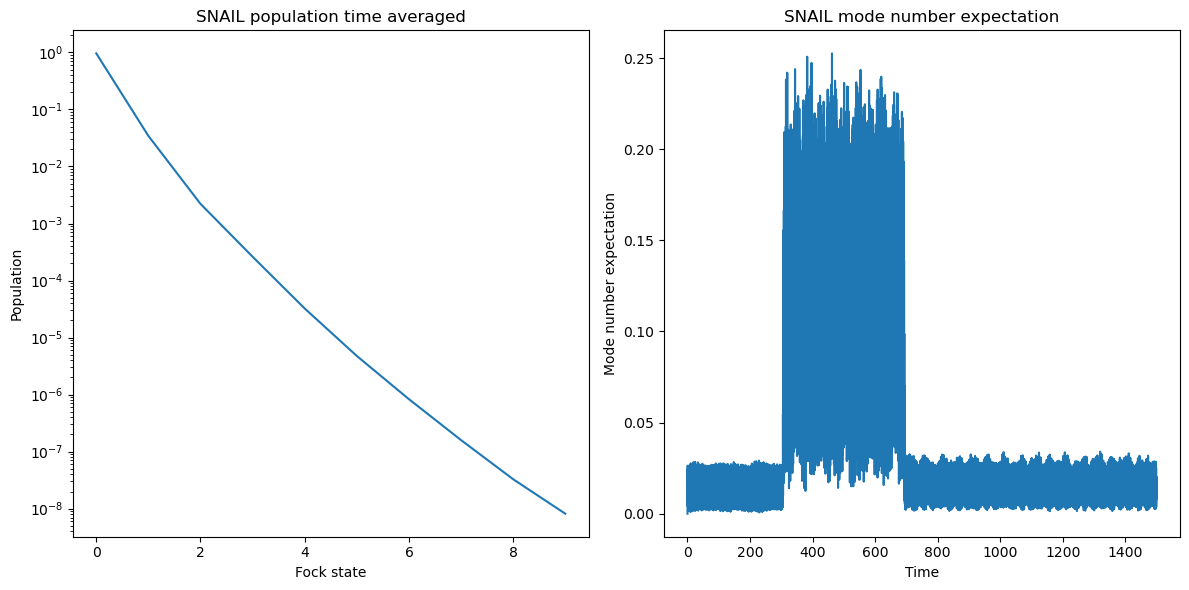

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(s_pop_tavg)
axs[0].set_yscale("log")
axs[0].set_xlabel("Fock state")
axs[0].set_ylabel("Population")
axs[0].set_title("SNAIL population time averaged")


s_num = [np.sum([s_pop[i, j] * j for j in range(system_hamiltonian.snail_mode.dim)]) for i in range(len(tlist))]
axs[1].plot(tlist, s_num)
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Mode number expectation")
axs[1].set_title("SNAIL mode number expectation")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()